# meg prep rewrite

This brings together a bunch of steps into a straight line for simpler use.

Some remaining questions

- invoke brainstorm with MCR
  - still need to automate creating the protocol
  - check the scripts can dump the plain .mat files
- automate clean up when results are done (or not, if we want to keep the protocol)
- sync processed results to s3/hf
- move data to the mode space, short time fourier transform

In [1]:
%pip install boto3 tvb-gdist mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.4/752.4 kB 9.0 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 57.8 MB/s eta 0:00:00m eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.2 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os, json

here you need your own credentials from https://db.humanconnectome.org

In [1]:
import boto3

client = boto3.client('s3', 
                     aws_access_key_id='nope',
                     aws_secret_access_key='nopenope')

In [130]:
sid = '162026'

objects = client.list_objects(
    Bucket='hcp-openaccess',
    Prefix=f'HCP_1200/{sid}/MEG/anatomy')

In [131]:
os.path.basename(objects['Contents'][0]['Key'])

'162026.L.inflated.4k_fs_LR.surf.gii'

In [132]:
anat_dir = f'/tmp/hcp/{sid}/anatomy'
os.makedirs(anat_dir, exist_ok=True)

In [133]:
for s3obj in objects['Contents']:
    s3path = s3obj['Key']
    dlpath = os.path.join(anat_dir, os.path.basename(s3path))
    print('downloading', dlpath, end='', flush=True)
    client.download_file('hcp-openaccess', s3path, dlpath)
    print(flush=True)

downloading /tmp/hcp/162026/anatomy/162026.L.inflated.4k_fs_LR.surf.gii
downloading /tmp/hcp/162026/anatomy/162026.L.midthickness.4k_fs_LR.surf.gii
downloading /tmp/hcp/162026/anatomy/162026.R.inflated.4k_fs_LR.surf.gii
downloading /tmp/hcp/162026/anatomy/162026.R.midthickness.4k_fs_LR.surf.gii
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_headmodel.mat
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_sourcemodel_2d.mat
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_sourcemodel_3d4mm.mat
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_sourcemodel_3d6mm.mat
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_sourcemodel_3d8mm.mat
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_transform.txt
downloading /tmp/hcp/162026/anatomy/T1w_acpc_dc_restore.nii.gz
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_headmodel.png
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_sourcemodel_2d.png
downloading /tmp/hcp/162026/anatomy/162026_MEG_anatomy_

In [134]:
# HCP_1200/%s/unprocessed/MEG/*/4D/c,rfDC

raw_dir = f'/tmp/hcp/{sid}/raw'
objects = client.list_objects(
    Bucket='hcp-openaccess',
    Prefix=f'HCP_1200/{sid}/unprocessed/MEG')

In [135]:
for obj in objects['Contents']:
    # print(obj['Key'], obj['Size']//1024, 'KB')
    key = obj['Key']
    fname = os.path.basename(key)
    _hcp, _sid, _unproc, _meg, task, _4d = os.path.dirname(key).split(os.sep)
    dlpath = f'{raw_dir}/{task}/{fname}'
    os.makedirs(os.path.dirname(dlpath), exist_ok=True)

    
    print('downloading', dlpath, end='', flush=True)
    client.download_file('hcp-openaccess', key, dlpath)
    print(flush=True)

downloading /tmp/hcp/162026/raw/1-Rnoise/c,rfDC
downloading /tmp/hcp/162026/raw/1-Rnoise/config
downloading /tmp/hcp/162026/raw/10-Motort/c,rfDC
downloading /tmp/hcp/162026/raw/10-Motort/config
downloading /tmp/hcp/162026/raw/10-Motort/e,rfhp1.0Hz,COH
downloading /tmp/hcp/162026/raw/10-Motort/e,rfhp1.0Hz,COH1
downloading /tmp/hcp/162026/raw/10-Motort/162026_MEG_Motort_run1.tab
downloading /tmp/hcp/162026/raw/10-Motort/162026_MEG_Motort_run1.xlsx
downloading /tmp/hcp/162026/raw/11-Motort/c,rfDC
downloading /tmp/hcp/162026/raw/11-Motort/config
downloading /tmp/hcp/162026/raw/11-Motort/e,rfhp1.0Hz,COH
downloading /tmp/hcp/162026/raw/11-Motort/e,rfhp1.0Hz,COH1
downloading /tmp/hcp/162026/raw/11-Motort/162026_MEG_Motort_run2.tab
downloading /tmp/hcp/162026/raw/11-Motort/162026_MEG_Motort_run2.xlsx
downloading /tmp/hcp/162026/raw/2-Pnoise/c,rfDC
downloading /tmp/hcp/162026/raw/2-Pnoise/config
downloading /tmp/hcp/162026/raw/3-Restin/c,rfDC
downloading /tmp/hcp/162026/raw/3-Restin/config
down

<h2> stop! </h2>

go run `megfield_pp0_new_subject` and `megfield_pp2` and the export function seem to run fine.

In [ ]:
!./brainstorm3.command /usr/local/MATLAB/MATLAB_Runtime/R2023b megfield_pp0_new_subject.m 162026

In [145]:
!./brainstorm3.command /usr/local/MATLAB/MATLAB_Runtime/R2023b megfield_pp2_clean_and_gain.m 162026

 
Please wait...
 
If it hangs for more than a few minutes: try pressing ENTER.
Alternatively, download Brainstorm for a different version of the Matlab Runtime.
(See the installation instructions on the Brainstorm website)
 
Gtk-Message: 13:34:28.275: Failed to load module "canberra-gtk-module"
 
BST> Starting Brainstorm:
BST> =================================
BST> BrainstormHomeDir = /home/duke/.mcrCache23.2/bst_ja0/bst_javabuil
BST> Version: 04-Oct-2023
BST> Deleting old process reports...
BST> Loading configuration file...
BST> Plugin brain2mesh: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/brain2mesh
BST> Plugin iso2mesh: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/iso2mesh
BST> Plugin brainentropy: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/brainentropy
BST> Plugin blackrock: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/blackrock
BST> Plugin neuroelectrics: /home/duke/.mcrCache23.2/bst_

Brainstorm  needs the protocol created first, check the example script at 

https://neuroimage.usc.edu/brainstorm/Tutorials/Scripting?highlight=%28script%29#Running_scripts_on_a_cluster

when all that is done, then you can 
<h3> continue </h3>

In [146]:
!du -h -d1 bstdb/hcp/data/162026/@raw5*

992K	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC
841M	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch
841M	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch_band
887M	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch_band_clean


In [147]:
!ls -lh bstdb/hcp/data/162026/@raw5*/

bstdb/hcp/data/162026/@raw5-Restin_c_rfDC/:
total 988K
-rw-rw-r-- 1 duke duke  315 nov.  24 13:22 brainstormstudy.mat
-rw-rw-r-- 1 duke duke  49K nov.  24 13:22 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke 930K nov.  24 13:22 data_0raw_c,rfDC.mat

bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch/:
total 841M
-rw-rw-r-- 1 duke duke 841M nov.  24 13:38 5-Restin_c_rfDC_notch.bst
-rw-rw-r-- 1 duke duke  321 nov.  24 13:38 brainstormstudy.mat
-rw-rw-r-- 1 duke duke  49K nov.  24 13:38 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke 5,1K nov.  24 13:38 data_0raw_5-Restin_c_rfDC_notch.mat

bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch_band/:
total 841M
-rw-rw-r-- 1 duke duke 841M nov.  24 13:44 5-Restin_c_rfDC_notch_band.bst
-rw-rw-r-- 1 duke duke  326 nov.  24 13:44 brainstormstudy.mat
-rw-rw-r-- 1 duke duke 991K nov.  24 13:49 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke 5,6K nov.  24 13:46 data_0raw_5-Restin_c_rfDC_notch_band.mat

bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch_band_clean/:
total 

looks like mne supports reading bst, so we can load the meg data directly, w/o duplicating it.

In [18]:
import mne

so once those scripts are done, we can compute the gdist,

In [19]:
import gdist
import scipy.io
import glob
import numpy as np

protopath = 'bstdb/hcp'

In [49]:
cortex = f'{protopath}/anat/{sid}/tess_cortex_mid.mat'

In [21]:
%%time
mat = scipy.io.loadmat(cortex)
vtx = mat['Vertices'] # nvtx,3
tri = mat['Faces'].astype(np.int32) # ntri,3
assert tri.min() == 1
assert vtx.shape[1] == tri.shape[1] == 3
gd = gdist.local_gdist_matrix(vtx, tri, 20.0, is_one_indexed=True).tocsr()
gd.data = gd.data.astype(np.float32)
scipy.io.savemat(cortex + '.gdist.mat', {'gdist': gd.tocsr()})

CPU times: user 4min 7s, sys: 1.78 s, total: 4min 9s
Wall time: 4min 7s


next we need to compute the local kernel on gdist and its eigenvalues,

array([ 1.        ,  1.09355991,  1.19587327,  1.30775907,  1.43011289,
        1.56391412,  1.71023378,  1.8702431 ,  2.04522287,  2.23657374,
        2.44582737,  2.67465876,  2.92489959,  3.19855292,  3.49780924,
        3.82506396,  4.18293659,  4.57429176,  5.00226208,  5.47027326,
        5.98207153,  6.5417536 ,  7.15379947,  7.82310829,  8.55503759,
        9.35544612, 10.23074081, 11.18792799, 12.23466951, 13.37934407,
       14.63111428, 16.        ])

In [50]:
%%time 
import scipy.sparse.linalg as sla

for i, k in enumerate(tqdm.tqdm(2**np.r_[:4:32j])):# [1, 2, 4, 8]:
    lc = gd.copy()
    lc.data = np.exp(-lc.data/(k)).astype('f')
    d, p = sla.eigs(lc, 230)
    # print(np.abs(d.imag).sum(), np.abs(p.imag).sum(), 'residual imag')
    np.savez(cortex + f'.lc_{k:0.3f}.npz', d=d.real, p=p.real)
    print(k)

  3%|▎         | 1/32 [01:11<37:06, 71.81s/it]

1.0


  6%|▋         | 2/32 [02:23<35:51, 71.71s/it]

1.0935599087586108


  9%|▉         | 3/32 [03:53<38:42, 80.10s/it]

1.1958732740441411


 12%|█▎        | 4/32 [05:15<37:44, 80.86s/it]

1.307759068450572


 16%|█▌        | 5/32 [06:41<37:09, 82.56s/it]

1.4301128875730535


 19%|█▉        | 6/32 [08:21<38:23, 88.61s/it]

1.5639141188489016


 22%|██▏       | 7/32 [10:02<38:32, 92.52s/it]

1.710233781114708


 25%|██▌       | 8/32 [11:42<38:00, 95.02s/it]

1.870243097631694


 28%|██▊       | 9/32 [13:28<37:43, 98.43s/it]

2.0452228712025367


 31%|███▏      | 10/32 [15:21<37:43, 102.90s/it]

2.23657373642327


 34%|███▍      | 11/32 [17:17<37:27, 107.00s/it]

2.445827371134936


 38%|███▊      | 12/32 [19:21<37:21, 112.07s/it]

2.674658756817634


 41%|████      | 13/32 [21:23<36:28, 115.16s/it]

2.9248995860659113


 44%|████▍     | 14/32 [23:40<36:29, 121.64s/it]

3.1985529244663353


 47%|████▋     | 15/32 [26:07<36:38, 129.35s/it]

3.4978092442389936


 50%|█████     | 16/32 [28:26<35:16, 132.26s/it]

3.82506395798502


 53%|█████▎    | 17/32 [30:49<33:51, 135.43s/it]

4.1829365928899485


 56%|█████▋    | 18/32 [33:18<32:34, 139.61s/it]

4.574291758863786


 59%|█████▉    | 19/32 [35:51<31:09, 143.78s/it]

5.0022620784583465


 62%|██████▎   | 20/32 [38:21<29:04, 145.42s/it]

5.470273262105569


 66%|██████▌   | 21/32 [40:43<26:28, 144.42s/it]

5.982071529392834


 69%|██████▉   | 22/32 [43:16<24:31, 147.12s/it]

6.5417535958703095


 72%|███████▏  | 23/32 [45:44<22:05, 147.25s/it]

7.153799465421252


 75%|███████▌  | 24/32 [48:23<20:05, 150.72s/it]

7.823108290683463


 78%|███████▊  | 25/32 [51:04<17:56, 153.82s/it]

8.555037588568537


 81%|████████▏ | 26/32 [53:47<15:40, 156.71s/it]

9.355446124781494


 84%|████████▍ | 27/32 [56:31<13:14, 158.91s/it]

10.230740810612149


 88%|████████▊ | 28/32 [59:28<10:57, 164.29s/it]

11.187927987386018


 91%|█████████ | 29/32 [1:02:32<08:30, 170.29s/it]

12.234669509083762


 94%|█████████▍| 30/32 [1:05:32<05:46, 173.20s/it]

13.379344072045395


 97%|█████████▋| 31/32 [1:08:41<02:57, 177.74s/it]

14.631114282676025


100%|██████████| 32/32 [1:11:56<00:00, 134.89s/it]

16.0
CPU times: user 7h 44s, sys: 10min 10s, total: 7h 10min 55s
Wall time: 1h 11min 56s


In [23]:
!ls -lh bstdb/hcp/anat/100307

total 354M
-rw-rw-r-- 1 duke duke  827 nov.  23 13:05 brainstormsubject.mat
-rw-rw-r-- 1 duke duke  68M nov.  23 13:04 subjectimage_T1w_acpc_dc_restore.mat
-rw-rw-r-- 1 duke duke 528K nov.  23 13:26 tess_cortex_mid.mat
-rw-rw-r-- 1 duke duke 245M nov.  23 14:13 tess_cortex_mid.mat.gdist.mat
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:14 tess_cortex_mid.mat.lc_1.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:16 tess_cortex_mid.mat.lc_2.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:18 tess_cortex_mid.mat.lc_4.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:21 tess_cortex_mid.mat.lc_8.npz
-rw-rw-r-- 1 duke duke  62K nov.  23 13:05 tess_head_bem_1922V.mat
-rw-rw-r-- 1 duke duke  13M nov.  23 13:05 tess_head_mask.mat
-rw-rw-r-- 1 duke duke 134K nov.  23 13:26 tess_innerskull_bem_1922V.mat
-rw-rw-r-- 1 duke duke  61K nov.  23 13:05 tess_outerskull_bem_1922V.mat


In [24]:
!ls -lh bstdb/hcp/data/100307/@raw5-Restin_c_rfDC_notch_band_clean

total 1,2G
-rw-rw-r-- 1 duke duke 828M nov.  23 13:25 5-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke  332 nov.  23 13:25 brainstormstudy.mat
-rw-rw-r-- 1 duke duke 991K nov.  23 13:25 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke  12K nov.  23 13:25 data_0raw_5-Restin_c_rfDC_notch_band_clean.mat
-rw-rw-r-- 1 duke duke  45M nov.  23 13:26 headmodel_surf_os_meg.mat
-rw-rw-r-- 1 duke duke 258M nov.  23 13:29 run_data.mat
-rw-rw-r-- 1 duke duke 547K nov.  23 13:29 run_time.mat


computing several lets us see which reconstructs the MEG data best.

lastly, do the equivalent of `prep-runs.py`, but with an updated export,

In [25]:
!ls -lh bstdb/hcp/data/100307/@raw3-Restin_c_rfDC_notch_band_clean

total 1,2G
-rw-rw-r-- 1 duke duke 850M nov.  23 13:25 3-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke  332 nov.  23 13:25 brainstormstudy.mat
-rw-rw-r-- 1 duke duke 990K nov.  23 13:25 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke  12K nov.  23 13:25 data_0raw_3-Restin_c_rfDC_notch_band_clean.mat
-rw-rw-r-- 1 duke duke  45M nov.  23 13:26 headmodel_surf_os_meg.mat
-rw-rw-r-- 1 duke duke 265M nov.  23 13:28 run_data.mat
-rw-rw-r-- 1 duke duke 558K nov.  23 13:28 run_time.mat


now let's rewrite the main body of the loop in prep runs,

In [51]:
bst = 'bstdb/hcp'
with open('./badchans2.json', 'r') as fd:
    badchans2 = json.load(fd)

# per subject
tess_path = f'{bst}/anat/{sid}/tess_cortex_mid.mat'
lceigs_path = glob.glob(f'{tess_path}.lc_*.npz')
cortex = scipy.io.loadmat(tess_path)
lceigs = [np.load(_) for _ in lceigs_path]

# per run load gain & channel list
folder = f'{bst}/data/{sid}/@raw5-Restin_c_rfDC_notch_band_clean'
gain_mat = scipy.io.loadmat(os.path.join(folder, 'headmodel_surf_os_meg.mat'))
chan4d = scipy.io.loadmat(os.path.join(folder, 'channel_4d_acc1.mat'))

# load meg run data
run_data = scipy.io.loadmat(f'{folder}/run_data.mat')['run_data']
run_time = scipy.io.loadmat(f'{folder}/run_time.mat')['run_time']
run_data.shape

(287, 251450)

In [66]:
lceigs_path[4]

'5.470'

In [67]:
lceigs_ks = np.array([float(p.split('_')[-1][:-4]) for p in lceigs_path])
lceigs_ks

array([ 8.   ,  2.925,  1.   ,  9.355,  5.47 ,  7.154,  4.574,  3.498,
        1.43 ,  3.825,  5.002,  1.87 ,  1.71 ,  2.237,  7.823, 16.   ,
        1.564, 10.231, 11.188,  2.   ,  5.982,  1.308, 13.379, 12.235,
        3.199,  2.045,  1.094, 14.631,  8.555,  6.542,  2.675,  4.183,
        2.446,  1.   ,  1.196,  4.   ])

In [68]:
# bad channels
runslug = os.path.basename(folder).split('_')[0][4:]
badnames = badchans2[sid][runslug]
badmask = np.array([_[0] in badnames for _ in chan4d['Channel']['Name'][0,:]])
assert badmask.sum() == len(badnames)

# keep channels which have finite gain and not on the bad channel list
okchan = np.c_[np.isfinite(gain_mat['Gain']).all(axis=1), ~badmask].all(axis=1)

In [69]:
# retain normal orientation and project to harmonics
gain_xyz = gain_mat['Gain'][okchan].reshape((okchan.sum(), -1, 3))
gain = np.sum(gain_xyz * cortex['VertNormals'], axis=2) # (okchan.sum(), nvtx)
pgains = np.array([gain @ lceig['p'] for lceig in lceigs])
print(pgains.shape, 'pgain.shape', end='', flush=True)

(36, 246, 230) pgain.shape

In [70]:
t = run_time[0]
sfreq = 1/(t[1] - t[0])
assert int(sfreq) == 678

chop = 5*int(sfreq)
run_data = run_data[okchan]*1e12 # rescale to ~(-1,1)
run_data, run_time = run_data[:,chop:-chop], run_time[chop:-chop]

In [71]:
pgains.shape, run_data.shape, gain.shape

((36, 246, 230), (246, 244670), (246, 8004))

In [33]:
assert pgains.shape[1] == run_data.shape[0]

this is the most convenient place to check reconstruction errors. 

- for different numbers of local connectivity eigevectors
- for each decay rate
- compute inverse
- apply inverse to data
- apply forward to inversed data
- compute sse

In [86]:
run_data.shape

(246, 244670)

In [88]:
pgi.shape, pg.shape

((246, 225), (225, 246))

In [90]:
%timeit -n1 -r1 pg.T.copy() @ (pgi.T.copy() @ run_data)
%timeit -n1 -r1 (run_data.T @ pgi) @ pg

444 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
304 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [123]:
import tqdm

sse = []
for k in tqdm.tqdm(np.r_[:10]*25+1):
    sse_k = []
    for i, pgain in enumerate(pgains):
        pg = pgain[:, :k].T
        pgi = np.linalg.pinv(pg)
        rdr = (run_data[:,::10].T @ pgi) @ pg
        # rdr /= rdr.ptp()
        # dFr *= dF.ptp()
        sse_k.append( np.sum(np.square(rdr - run_data[:,::10].T)) )
    sse.append(sse_k)
sse = np.array(sse)

100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


In [124]:
sort_ks = np.argsort(lceigs_ks)
sort_ks

array([ 2, 33, 26, 34, 21,  8, 16, 12, 11, 19, 25, 13, 32, 30,  1, 24,  7,
        9, 35, 31,  6, 10,  4, 20, 29,  5, 14,  0, 28,  3, 17, 18, 23, 22,
       27, 15])

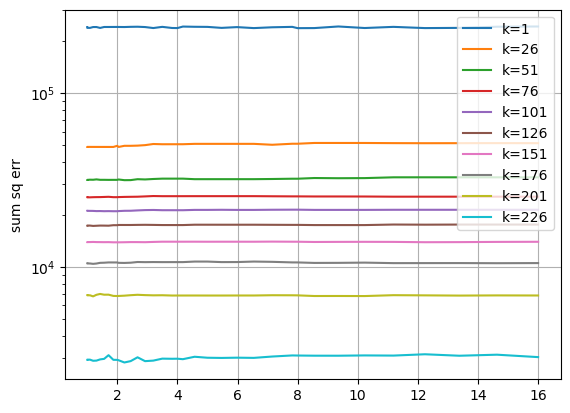

In [126]:
import matplotlib.pyplot as pl

pl.semilogy(lceigs_ks[sort_ks],sse[:,sort_ks].T)
pl.grid(1)
# pl.ylim([0, sse.max()*1.1])
pl.ylabel('sum sq err')
pl.legend([f'k={k}' for k in np.r_[:10]*25+1])
pl.show()

In [128]:
sse[4].mean() / sse[0].mean()

0.08820321175063353

from this, it doesn't seem to matter much which k is used, as long as we have enough modes. the 5th line, green here, is 101 modes, which retains only 8% of the sum squared error compared to using 1 mode.  This seems consistent with the connectome mode paper.

In [144]:

dF = run_data.T
pgain = pgains[2]
sse = [np.sum(np.square(dF))]
for k in tqdm.trange(1,150):
    pg = pgain[:, :k].T
    pgi = np.linalg.pinv(pg)
    dFr = (dF @ pgi) @ pg
    dFr /= dFr.ptp()
    # dFr *= dF.ptp()
    sse.append( np.sum(np.square(dFr - dF)) )
sse = np.array(sse)

100%|████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.59it/s]


In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
figure(figsize=(5,4))
plot(100-sse/sse.max()*100)
axhline(100-full_sse / sse.max()*100, color='r')
grid(1)
ylim([0,50])
xlabel('# of cortical harmonics')
ylabel('% variance reconstructed')
legend(('Harmonics', '8004 vertex cortex'))

NameError: name 'figure' is not defined

actually this fits the results from the previous analysis, so it seems fine.

In [133]:
igain = np.linalg.pinv(gain)

In [135]:
igain.shape, dF.shape

((8004, 246), (244670, 246))

In [137]:
dFr = ((dF @ igain.T) @ gain.T).T
dFr /= dFr.ptp()

In [138]:
full_sse = np.sum(np.square(dFr.T - dF))

In [142]:
full_sse/dF.shape[0], 'per time point'

(7.107777504446888, 'per time point')

now do that with Torch: the big matrix operations are much faster.

In [168]:
import torch

dF = torch.tensor(run_data.T).to('mps')

pgain = pgains[2]
to_mps = lambda x: torch.tensor(x.astype('f')).to('mps')

sses = []
for i in range(4):
    sse = [torch.sum(torch.square(dF))]
    for k in tqdm.trange(1,100):
        pg = pgains[i, :, :k].T
        pgi = np.linalg.pinv(pg)
        pg, pgi = to_mps(pg), to_mps(pgi)
        dFr = (dF @ pgi) @ pg
        dFr /= torch.max(dFr) - torch.min(dFr)
        # dFr *= dF.ptp()
        sse.append( torch.sum(torch.square(dFr - dF)) )
    sse = torch.tensor(sse)
    sses.append(sse)

100%|██████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 21.17it/s]


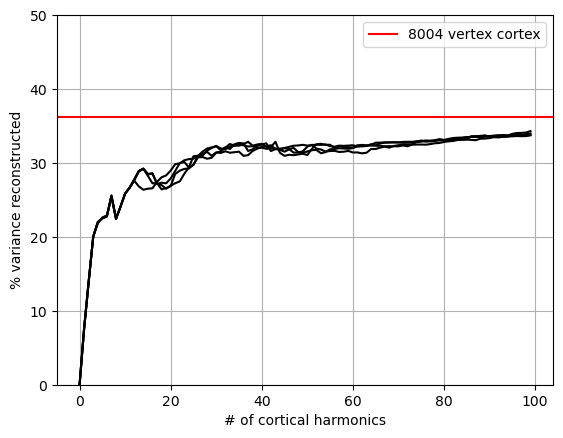

In [173]:
sses = np.array(sses)
axhline(100-full_sse / sses.T.max()*100, color='r')
plot(100-sses.T/sses.max()*100, 'k')
grid(1)
ylim([0,50])
xlabel('# of cortical harmonics')
ylabel('% variance reconstructed')
legend(('8004 vertex cortex', ))

## move data to spectral domain

So far, MEG data are in the time domain at sensor level.  A more compact representation easy for modeling purposes will be a short time Fourier or wavelet representation and in terms of mode coefficients.

- https://pytorch-wavelets.readthedocs.io/en/latest/dwt.html

This will reduce significantly the space taken up by the data and the compute required for modeling purposes.